### 1. Dependencies

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import DataParallel

import time
import os
import numpy as np
import json
import cv2
from PIL import Image, ImageOps
import random
from tqdm import tqdm
import operator
import itertools
from scipy.io import  loadmat
import logging
from scipy import signal

from utils import data_transforms
from utils import get_paste_kernel, kernel_map
from utils_logging import setup_logger

### 2. Choose between Recasens or GazeNet

- Idea is you can just swap 
models.recasens, dataloader.recasens, training.train_recasens, etc...
- with the following
models.gazenet, dataloader.gazenet, training.train_gazenet

In [2]:
from models.recasens import GazeNet
from dataloader.recasens import GooDataset, GazeDataset, RetailGaze
from models.__init__ import save_checkpoint, resume_checkpoint
from training.train_recasens import train, test, GazeOptimizer

In [3]:
# Logger will save the training and test errors to a .log file 
logger = setup_logger(name='first_logger', 
                      log_dir ='./logs/',
                      log_file='train_recasens_newauc.log',
                      log_format = '%(asctime)s %(levelname)s %(message)s',
                      verbose=True)

### 3. Dataloaders
- Choose between GazeDataset (Gazefollow dataset) or GooDataset (GooSynth/GooReal)
- Set paths to image directories and pickle paths. For Gazefollow, images_dir and test_images_dir should be the same and both lead to the path containing the train and test folders.

In [4]:
# Dataloaders for GazeFollow
batch_size=64
workers=12
testbatchsize=batch_size*2

images_dir = '/Users/shashimalsenarath/Downloads/RetailGaze_V2-2/'
pickle_path = '/Users/shashimalsenarath/Downloads/RetailGaze_V3_train.pickle'
test_images_dir = '/Users/shashimalsenarath/Downloads/RetailGaze_V2-2/'
test_pickle_path = '/Users/shashimalsenarath/Downloads/RetailGaze_V3_test.pickle'

train_set = RetailGaze(images_dir, pickle_path, 'train')
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

val_set = RetailGaze(test_images_dir, test_pickle_path, 'test')
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=testbatchsize, num_workers=workers, shuffle=False)

Total images in this set: 2745
Total images in this set: 589


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


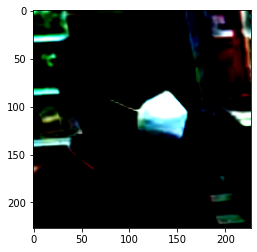

In [6]:
sample =  next(iter(train_set))
import matplotlib.pyplot as plt

plt.imshow(sample[1].numpy().transpose(1,2,0))
plt.savefig("image.png")


In [4]:
# Dataloaders for GOO-Synth
batch_size=32
workers=12
testbatchsize=32

images_dir = '/hdd/HENRI/goosynth/1person/GazeDatasets/'
pickle_path = '/hdd/HENRI/goosynth/picklefiles/trainpickle2to19human.pickle'
test_images_dir = '/hdd/HENRI/goosynth/test/'
test_pickle_path = '/hdd/HENRI/goosynth/picklefiles/testpickle120.pickle'

train_set = GooDataset(images_dir, pickle_path, 'train')
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

val_set = GooDataset(test_images_dir, test_pickle_path, 'test')
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=testbatchsize, num_workers=workers, shuffle=False)

Total images in this set: 172800
Total images in this set: 19200


In [4]:
# Dataloaders for GOO-Real

batch_size=32
workers=12
testbatchsize=32

images_dir = '/home/eee198/Documents/datasets/GOOReal/finalrealdatasetImgsV2/'
pickle_path = '/home/eee198/Documents/datasets/GOOReal/oneshotrealhumans.pickle'
test_images_dir = '/home/eee198/Documents/datasets/GOOReal/finalrealdatasetImgsV2/'
test_pickle_path = '/home/eee198/Documents/datasets/GOOReal/testrealhumans.pickle'

train_set = GooDataset(images_dir, pickle_path, 'train')
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=workers)

val_set = GooDataset(test_images_dir, test_pickle_path, 'test')
test_data_loader = torch.utils.data.DataLoader(val_set, batch_size=testbatchsize, num_workers=workers, shuffle=False)

Total images in this set: 2451
Total images in this set: 2156


### 4. Load Model and Set Training Hyperparameters
- For Gazefollow, the model requires the alexnet_places365 pretrained model, provided here: https://urlzs.com/ytKK3
- When resuming training, set to True and set the resume_path for the saved model.
- Here, logging module is initialized (logger) to save training and testing errors.

In [5]:
# Loads model

net = GazeNet(placesmodel_path='./alexnet_places365.pth')
net.cuda()

# Hyperparameters
start_epoch = 0
max_epoch = 5
learning_rate = 1e-4

# Initializes Optimizer
gaze_opt = GazeOptimizer(net, learning_rate)
optimizer = gaze_opt.getOptimizer(start_epoch)

# Is training resumed? If so, set the resume_path and set flag to True
resume_training = True
resume_path = './saved_models/completed/recasens_goo_epoch4.pth.tar'
if resume_training :
    net, optimizer, _ = resume_checkpoint(net, optimizer, resume_path)
    test(net, test_data_loader,logger, save_output=True)


  0%|          | 0/68 [00:00<?, ?it/s]

=> loading checkpoint './saved_models/completed/recasens_goo_epoch4.pth.tar'
=> loaded checkpoint './saved_models/completed/recasens_goo_epoch4.pth.tar' (epoch 5)


100%|██████████| 68/68 [01:21<00:00,  1.20s/it]
proximate accuracy: [0.00231911 0.00974026 0.02365492 0.10204082 0.22588126 0.32235622
 0.43599258 0.53339518]
average error: [0.7020923813740372, 0.31269916848244217, 73.99956924930054]


In [6]:
test(net, test_data_loader,logger, save_output=True)

100%|██████████| 68/68 [01:23<00:00,  1.23s/it]
proximate accuracy: [0.00046382 0.00463822 0.01205937 0.03942486 0.07977737 0.16233766
 0.25695733 0.33534323]
average error: [0.4597496690213444, 0.3882146535767388, 68.89116375273363]


[0.4597496690213444, 0.3882146535767388, 68.89116375273363]

### 5. Training the Model
- Determine in which epochs do you want to save the model, as you might not want to save every epoch
- Training and test errors can be accessed in the logs directory set up earlier

In [7]:
best_l2 = np.inf

for epoch in range(1,5):
    
    # Update optimizer
    optimizer = gaze_opt.getOptimizer(epoch)

    # Train model
    train(net, train_data_loader, optimizer, epoch, logger)
    
    # Evaluate model
    if epoch+1 in [1,5]:
        scores = test(net, test_data_loader, logger, save_output=True)
    
    # Save model+optimizer with best L2 Score
    #if scores[1] < best_l2:
    #    best_l2 = scores[1]
    #    save_path = './saved_models/recasens_gooreal_notrain/'
    #    save_checkpoint(net, optimizer, 0, save_path)

100%|██████████| 68/68 [01:24<00:00,  1.24s/it]
proximate accuracy: [0.00278293 0.02922078 0.06957328 0.23237477 0.466141   0.64007421
 0.7458256  0.82792208]
average error: [0.903229810803981, 0.1952449509308719, 39.84618047878634]


In [8]:
test(net, test_data_loader, logger, save_output=True)

100%|██████████| 68/68 [01:23<00:00,  1.23s/it]
proximate accuracy: [0.00092764 0.00742115 0.02179963 0.06307978 0.12337662 0.20269017
 0.30333952 0.40862709]
average error: [0.6879634857505997, 0.3473641554752535, 75.32601067892568]


[0.6879634857505997, 0.3473641554752535, 75.32601067892568]